# Revenue Modeling: Amusement

**Purpose:** For the tax revenue of interest, explore forecasts, testing out different combinations of 
endog and exog variables.

Once the best fit is determined, we can plug the parameters into the main "parameters.yml" file and run reproducible model fits through the command line using `fyp-analysis run`.

In [1]:
TAX_NAME = "Amusement"
TAX_BASE_COLUMN = f"{TAX_NAME}Base"

## Software Setup

If changes are made to the analysis code, run the below cell to reload the changes:

In [2]:
%reload_kedro

2021-07-05 13:36:05,563 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-07-05 13:36:05,664 - root - INFO - ** Kedro project Five Year Plan Analysis
2021-07-05 13:36:05,666 - root - INFO - Defined global variable `context`, `session` and `catalog`


Imports:

In [3]:
from fbprophet import Prophet

2021-07-05 13:36:06,099 - fbprophet.plot - ERROR - Importing plotly failed. Interactive plots will not work.


In [4]:
# Base imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from phila_style.matplotlib import get_theme

# Prediction functions
from fyp_analysis.pipelines.modeling.predict import (
    get_possible_endog_variables,
    run_possible_models,
    fit_var_model,
    plot_forecast_results,
    plot_projection_comparison,
    aggregate_to_fiscal_year,
)

# The main preprocess pipeline
from fyp_analysis.pipelines.data_processing.preprocess import PreprocessPipeline
from fyp_analysis.extras.datasets import load_cbo_data, Taxes

/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [5]:
pd.options.display.max_columns = 999

## Parameter Setup

Set up the data catalog. We can use `DATA.load()` to load specific data instances.

In [6]:
DATA = context.catalog

Available data:

In [7]:
DATA.list()

['economic_indicators',
 'quarterly_features_raw',
 'quarterly_features_cbo_imputed',
 'features_and_bases',
 'features_and_bases_sa',
 'stationary_guide',
 'final_unscaled_features',
 'final_scaled_features',
 'scaled_feature_correlations',
 'grangers_matrix',
 'possible_endog_variables',
 'plan_details',
 'wage_fit_params',
 'sales_fit_params',
 'net_income_fit_params',
 'gross_receipts_fit_params',
 'rtt_fit_params',
 'parking_fit_params',
 'amusement_fit_params',
 'npt_fit_params',
 'parameters',
 'params:fresh_indicators',
 'params:seasonal_adjustments',
 'params:min_feature_year',
 'params:max_fit_date',
 'params:grangers_maxlag',
 'params:grangers_max_date',
 'params:plan_start_year',
 'params:cbo_forecast_date']

Load the parameter dict too:

In [8]:
PARAMS = context.params

In [9]:
PARAMS

{'fresh_indicators': False,
 'seasonal_adjustments': ['ActivityLicensesPhilly',
  'BizLicensesPhilly',
  'BuildingPermitsPhilly',
  'CPIPhillyMSA',
  'ContinuedClaimsPA',
  'WeeklyEconomicIndex',
  'DeedTransfersPhilly',
  'InitialClaimsPA',
  'UncertaintyIndex',
  'UnemploymentPhilly'],
 'min_feature_year': 1996,
 'max_fit_date': '2021-06-30',
 'grangers_maxlag': 6,
 'grangers_max_date': '2019-12-31',
 'plan_start_year': 2022,
 'cbo_forecast_date': 'latest'}

Extract specific parameters:

In [10]:
# Trim features to this start year
min_year = PARAMS["min_feature_year"]

# When is the CBO forecast from?
cbo_forecast_date = PARAMS["cbo_forecast_date"]

# First fiscal year of the plan
plan_start_year = PARAMS["plan_start_year"]

## Data Setup

Load the correlation matrix and Granger matrix:

In [11]:
C = DATA.load("scaled_feature_correlations") # correlation matrix
G = DATA.load("grangers_matrix") # Granger matrix

2021-07-05 13:36:10,768 - kedro.io.data_catalog - INFO - Loading data from `scaled_feature_correlations` (ExcelDataSet)...
2021-07-05 13:36:11,203 - kedro.io.data_catalog - INFO - Loading data from `grangers_matrix` (ExcelDataSet)...


Load taxes object responsible for loading historical tax data"

In [12]:
# Load the Plan details we are using
plan_details = DATA.load("plan_details")

# All taxes
all_taxes = Taxes(plan_details)

# This tax
this_tax = all_taxes[TAX_NAME]

2021-07-05 13:36:11,395 - kedro.io.data_catalog - INFO - Loading data from `plan_details` (PlanDetailsYAMLDataSet)...


Data associated with a tax is stored in the `.data` attribute:

In [13]:
this_tax.data.head()

,fiscal_quarter,fiscal_year,AmusementRevenue,rate,AmusementBase
0,1,1996,2247483.20,0.05,44949664.0
1,2,1996,2288836.94,0.05,45776738.8
2,3,1996,1261068.06,0.05,25221361.2
3,4,1996,1805506.60,0.05,36110132.0
4,1,1997,2297466.67,0.05,45949333.4


Load the final unscaled features:

In [14]:
unscaled_features = DATA.load("final_unscaled_features")

2021-07-05 13:36:12,031 - kedro.io.data_catalog - INFO - Loading data from `final_unscaled_features` (CSVDataSet)...


In [15]:
unscaled_features.head()

,YieldCurve,SahmRule,WagesPhillyMSA,NonfarmEmployeesPhillyMSA,NonfarmEmployeesPhilly,PersonalSavingsRate,NYCGasPrice,CarSales,RealRetailFoodServiceSales,UnemploymentRate,PPI,UnemploymentPhillyMSA,UnemploymentPhilly,CorporateProfits,RealGDP,AlcoholSales,PrimeEPOP,UncertaintyIndex,HousePriceIndexPhillyMSA,BuildingPermitsPhillyMSA,EconomicConditionsPhillyMSA,CPIPhillyMSA,InitialClaimsPA,ContinuedClaimsPA,NewManufacturingOrders,ConsumerConfidence,ManufacturingHoursWorked,PCE,RealDisposablePersonalIncome,HousingStarts,HousingSupply,GovtSocialBenefits,GDPPriceIndex,GDP,PCEPriceIndex,CPIU,10YearTreasury,3MonthTreasury,FedFundsRate,OilPriceWTI,FHFAHousePriceIndex,NonfarmEmployment,PersonalIncome,Wage&Salaries,NonresidentialInvestment,ResidentialInvestment,TotalBusinessSales,SP500,MedianHomeValuePhilly,AmusementBase,GrossReceiptsBase,NetIncomeBase,NPTBase,ParkingBase,RTTBase,SalesBase,WageBase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-01-01,0.640323,0.133333,633.494864,2488.200000,673.300000,6.666667,0.540810,15.481000,136411.666667,5.533333,126.300000,5.666667,7.615251,772.255,10817.896,1929.333333,79.866667,85.211652,105.35,1192.461261,2.993333,161.128928,24286.348514,183207.426031,48964.666667,100.506111,40.700000,5130.600000,7867.333333,1460.666667,5.966667,674.991,72.700,7868.468,72.700000,155.066667,5.910000,4.930000,5.363333,19.760000,113.72,118682.666667,6520.965,3524.466667,1003.747,344.725,665407.333333,637.010000,70409.666667,25221361.2,2.187766e+08,2.247482e+08,3.846310e+07,4.505538e+07,4.173158e+08,2.202701e+09,5.879433e+09
1996-04-01,0.603281,-0.023333,634.204732,2518.700000,673.933333,6.500000,0.641175,15.571667,137903.333333,5.500000,127.833333,5.466667,7.303317,784.776,10998.322,1930.666667,80.000000,76.013567,103.48,1419.918127,4.320000,162.290804,21465.862561,162774.104738,50054.333333,100.703103,41.366667,5220.533333,7939.400000,1495.666667,5.966667,680.667,72.997,8032.840,73.186667,156.400000,6.720000,5.020000,5.243333,21.696667,114.47,119471.000000,6649.846,3589.933333,1026.468,361.399,683338.666667,658.966667,70070.666667,36110132.0,1.794259e+09,1.843234e+09,2.124595e+08,4.785091e+07,3.134791e+08,1.707329e+09,5.672519e+09
1996-07-01,0.600000,-0.066667,634.799371,2526.300000,675.900000,6.666667,0.616141,15.364667,138152.333333,5.266667,128.166667,5.366667,7.134090,790.044,11096.976,1944.000000,80.433333,76.992374,102.40,1450.454374,2.470000,163.260178,20989.538331,156320.048762,50550.333333,101.087051,41.500000,5274.500000,8003.700000,1501.333333,5.300000,683.711,73.352,8131.408,73.498667,157.300000,6.780000,5.096667,5.306667,22.390000,115.21,120208.000000,6725.853,3647.233333,1058.965,364.315,690877.000000,660.543333,69872.333333,45949333.4,1.363051e+08,1.376918e+08,1.790954e+07,4.440285e+07,4.318287e+08,2.141674e+09,5.718973e+09
1996-10-01,0.550484,0.033333,645.667612,2537.900000,672.033333,6.400000,0.676531,15.401000,139499.000000,5.333333,128.433333,5.266667,7.227878,810.914,11212.205,1906.666667,80.533333,62.134681,103.38,1585.019678,3.286667,164.630069,21427.940357,153523.202698,51995.000000,101.427253,41.533333,5352.766667,8046.366667,1417.000000,5.266667,688.911,73.662,8259.771,73.999333,158.666667,6.343333,4.976667,5.280000,24.606667,115.87,120923.000000,6817.457,3704.266667,1083.597,361.806,699627.333333,726.793333,69969.333333,56777070.2,4.502762e+07,4.548571e+07,2.239441e+07,4.687521e+07,5.769549e+08,2.126915e+09,5.793457e+09
1997-01-01,0.522333,0.120000,651.303280,2556.266667,666.600000,6.266667,0.638361,15.589667,140960.666667,5.233333,128.500000,5.100000,7.045607,839.036,11284.587,1950.333333,80.500000,58.548248,103.72,1665.828907,3.503333,165.722588,18587.041742,149251.881603,53479.333333,101.677271,41.600000,5433.100000,8123.000000,1432.666667,4.433333,704.464,73.992,8362.655,74.326000,159.633333,6.563333,5.060000,5.276667,22.760000,116.60,121676.000000,6939.356,3776.366667,1107.299,365.359,713321.666667,785.590000,70345.666667,26804719.4,2.626964e+08,2.653690e+08,4.589743

The final scaled features:

In [16]:
scaled_features = DATA.load("final_scaled_features")

2021-07-05 13:36:12,124 - kedro.io.data_catalog - INFO - Loading data from `final_scaled_features` (CSVDataSet)...


In [17]:
scaled_features.head()

,D.YieldCurve,D.SahmRule,D.D.Ln.WagesPhillyMSA,D.Ln.NonfarmEmployeesPhillyMSA,D.Ln.NonfarmEmployeesPhilly,D.Ln.PersonalSavingsRate,D.Ln.NYCGasPrice,D.Ln.CarSales,D.Ln.RealRetailFoodServiceSales,D.Ln.UnemploymentRate,D.Ln.PPI,D.Ln.UnemploymentPhillyMSA,D.Ln.UnemploymentPhilly,D.Ln.CorporateProfits,D.Ln.RealGDP,D.Ln.AlcoholSales,D.Ln.PrimeEPOP,D.Ln.UncertaintyIndex,D.D.Ln.HousePriceIndexPhillyMSA,D.Ln.BuildingPermitsPhillyMSA,D.EconomicConditionsPhillyMSA,D.Ln.CPIPhillyMSA,D.Ln.InitialClaimsPA,D.Ln.ContinuedClaimsPA,D.Ln.NewManufacturingOrders,D.Ln.ConsumerConfidence,D.Ln.ManufacturingHoursWorked,D.Ln.PCE,D.Ln.RealDisposablePersonalIncome,D.Ln.HousingStarts,D.Ln.HousingSupply,D.D.Ln.GovtSocialBenefits,D.Ln.GDPPriceIndex,D.Ln.GDP,D.Ln.PCEPriceIndex,D.Ln.CPIU,D.Ln.10YearTreasury,D.Ln.3MonthTreasury,D.Ln.FedFundsRate,D.Ln.OilPriceWTI,D.Ln.FHFAHousePriceIndex,D.Ln.NonfarmEmployment,D.Ln.PersonalIncome,D.Ln.Wage&Salaries,D.Ln.NonresidentialInvestment,D.Ln.ResidentialInvestment,D.Ln.TotalBusinessSales,D.Ln.SP500,D.D.Ln.MedianHomeValuePhilly,D.Ln.AmusementBase,D.GrossReceiptsBase,D.NetIncomeBase,D.NPTBase,D.Ln.ParkingBase,D.Ln.RTTBase,D.Ln.SalesBase,D.Ln.WageBase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997-01-01,-0.028151,0.086667,-0.008285,0.007211,-0.008118,-0.021053,-0.058075,0.012176,0.010423,-0.018928,0.000519,-0.032157,-0.025541,0.034092,0.006435,0.022644,-0.000414,-0.059453,-0.006241,0.049726,0.216667,0.006614,-0.142231,-0.028216,0.028148,0.002462,0.001604,0.014896,0.009479,0.010996,-0.172246,0.014748,0.004470,0.012379,0.004405,0.006074,0.034094,0.016606,-0.000632,-0.078013,0.006280,0.006208,0.017722,0.019277,0.021638,0.009772,0.019385,0.077793,0.003977,-0.750555,0.043920,0.040621,0.074343,-0.016236,-0.369991,0.075583,0.049908
1997-04-01,-0.098583,-0.223333,-0.005558,0.005163,-0.001902,0.056863,-0.084651,-0.045918,-0.004463,-0.045611,-0.010168,-0.033226,-0.014045,0.026578,0.016483,0.021473,0.002894,0.299199,-0.006567,-0.090230,-0.070000,0.002961,0.087875,-0.030346,0.027674,0.005314,0.002401,0.006994,0.008829,0.029798,0.029632,-0.017957,0.004975,0.018502,0.002504,0.002294,0.020111,-0.002639,0.045687,-0.132946,0.008115,0.007146,0.011878,0.015572,0.019911,0.018758,0.006936,0.048265,-0.001109,0.674485,0.167152,0.138132,-0.018271,0.089694,-0.014438,-0.094648,-0.047583
1997-07-01,-0.085312,0.103333,0.012688,0.008757,0.001302,-0.083819,0.083351,0.046837,0.016635,-0.027029,0.000000,-0.041385,-0.007421,0.039824,0.012431,0.011972,0.005353,-0.268545,0.012143,-0.023355,0.820000,0.004391,0.017352,-0.014462,0.072510,0.003295,-0.000800,0.019535,0.011695,-0.012499,-0.060169,-0.002059,0.002954,0.016762,0.002636,0.004988,-0.070096,0.000000,0.001809,-0.006209,0.007289,0.005812,0.015969,0.017402,0.042293,0.017771,0.015111,0.120323,-0.001461,-0.143395,-0.018339,-0.021556,0.048985,-0.087370,0.410222,0.288893,0.039920
1997-10-01,-0.166663,-0.066667,0.012970,0.008464,0.009511,0.037538,-0.141757,0.019421,-0.000832,-0.041964,0.002356,-0.035846,-0.044643,-0.016932,0.008551,0.018992,-0.001644,0.130184,0.001062,0.056339,-0.476667,-0.000259,0.007374,0.016934,-0.019323,-0.000241,0.004789,0.015026,0.014623,0.049737,-0.023530,-0.000816,0.003574,0.011829,0.003132,0.005375,-0.055433,0.008550,-0.004831,0.007379,0.010752,0.007876,0.019115,0.022656,0.002339,0.017790,0.006278,0.022298,-0.005815,0.317877,0.063651,0.061508,-0.060980,0.064860,0.187705,-0.223446,0.016527
1998-01-01,-0.030463,0.056667,-0.039897,0.005303,0.003315,0.160148,-0.189621,-0.049476,0.004998,-0.007168,-0.019536,-0.029632,-0.002417,-0.081392,0.009945,0.014810,-0.000411,0.227152,0.008234,0.189062,-1.206667,0.001211,0.012982,-0.016309,-0.000604,0.002640,-0.003190,0.010136,0.020831,0.017257,-0.048790,0.011728,0.001015,0.011408,0.000076,0.002060,-0.055699,-0.007230,0.002418,-0.222726,0.012372,0.006096,0.021968,0.020454,0.026118,0.023296,0.005541,0.071520,-0.000397,-0.638450,-0.040535,-0.046653,0.098343,-0.008739,-0.017401,-0.021794,0.050521


Determine the name of the scaled tax base column:

In [18]:
SCALED_COLUMN = [col for col in scaled_features.columns if TAX_BASE_COLUMN in col][0]

In [19]:
SCALED_COLUMN

'D.Ln.AmusementBase'

Initialize the preprocesser that goes from unscaled to scaled features:

In [20]:
guide = DATA.load("stationary_guide")
preprocess = PreprocessPipeline(guide)

2021-07-05 13:36:12,308 - kedro.io.data_catalog - INFO - Loading data from `stationary_guide` (ExcelDataSet)...


In [21]:
guide.head()

,variable,ndiffs,loggable,norm,periods
0,BuildingPermitsPhilly,1,True,1,1
1,ActivityLicensesPhilly,1,True,1,1
2,BizLicensesPhilly,2,True,1,1
3,DeedTransfersPhilly,1,True,1,1
4,YieldCurve,1,False,1,1


In [22]:
guide.tail(n=10)

,variable,ndiffs,loggable,norm,periods
58,MedianListPricePhillyMSA,2,True,1,1
59,RentIndexPhillyMSA,1,True,1,1
60,AmusementBase,1,True,1,1
61,GrossReceiptsBase,1,False,1000000000,4
62,NetIncomeBase,1,False,1000000000,4
63,NPTBase,1,False,100000000,4
64,ParkingBase,1,True,1,1
65,RTTBase,1,True,1,1
66,SalesBase,1,True,1,1
67,WageBase,1,True,1,1


Load the CBO data frame:

In [23]:
cbo_data = load_cbo_data(date=cbo_forecast_date)
cbo_columns = cbo_data.columns.tolist()

In [24]:
cbo_data.head()

var1,10YearTreasury,3MonthTreasury,CPIU,CorporateProfits,FHFAHousePriceIndex,FedFundsRate,GDPPriceIndex,NonfarmEmployment,NonresidentialInvestment,OilPriceWTI,PCE,PCEPriceIndex,PersonalIncome,RealGDP,ResidentialInvestment,UnemploymentRate,Wage&Salaries
Date,,,,,,,,,,,,,,,,,
2017-01-01,2.443,0.590,243.752,2064.1,235.71,0.700,107.031,145780.0,2532.5,51.77,13153.2,105.421,16633.7,17977.3,746.0,4.566,8308.8
2017-04-01,2.263,0.890,244.187,2103.0,240.00,0.950,107.368,146318.0,2555.9,48.24,13241.3,105.654,16828.4,18054.1,753.3,4.400,8399.9
2017-07-01,2.243,1.036,245.345,2136.0,243.79,1.153,107.968,146874.0,2575.2,48.16,13370.9,106.084,17036.6,18185.6,758.5,4.300,8515.3
2017-10-01,2.370,1.206,247.257,2155.0,247.36,1.203,108.637,147405.0,2634.2,55.37,13596.0,106.775,17295.6,18359.4,783.6,4.133,8661.8
2018-01-01,2.760,1.560,249.179,2206.0,252.08,1.446,109.292,147988.0,2716.2,62.89,13755.5,107.485,17548.6,18530.5,794.3,4.033,8756.4


## Forecast

In this section, we use a combination of correlations, Granger matrix, and intuition to select possible endogenous variables to include in the VAR fit. Then, we do a grid search to find the bestfit parameters based on accuracy on historical data:

### Correlations

Get top and bottom 10 correlations with our tax base:

In [25]:
C[SCALED_COLUMN].sort_values().head(n=10)

D.SahmRule                          -0.447684
D.Ln.UnemploymentPhilly             -0.393864
D.Ln.ContinuedClaimsPA              -0.344447
D.Ln.RealDisposablePersonalIncome   -0.309367
D.Ln.AlcoholSales                   -0.297933
D.Ln.PersonalIncome                 -0.295664
D.Ln.UnemploymentPhillyMSA          -0.282839
D.Ln.UnemploymentRate               -0.257936
D.Ln.PersonalSavingsRate            -0.176291
D.Ln.WageBase                       -0.148547
Name: D.Ln.AmusementBase, dtype: float64

In [26]:
C[SCALED_COLUMN].sort_values().tail(n=10)

D.D.Ln.WagesPhillyMSA          0.199073
D.Ln.PrimeEPOP                 0.208934
D.Ln.NonfarmEmployment         0.221087
D.Ln.HousingSupply             0.229762
D.Ln.RTTBase                   0.233910
D.Ln.FedFundsRate              0.234906
D.Ln.NonfarmEmployeesPhilly    0.238934
D.Ln.10YearTreasury            0.301718
D.Ln.ParkingBase               0.440127
D.Ln.AmusementBase             1.000000
Name: D.Ln.AmusementBase, dtype: float64

Load the possible endog variables:

In [27]:
possible_endog = DATA.load('possible_endog_variables')[SCALED_COLUMN]

2021-07-05 13:36:13,178 - kedro.io.data_catalog - INFO - Loading data from `possible_endog_variables` (JSONDataSet)...


In [28]:
possible_endog

['WageBase',
 'RTTBase',
 'PersonalSavingsRate',
 'GovtSocialBenefits',
 'HousingSupply',
 '3MonthTreasury',
 'UnemploymentPhilly',
 'PPI',
 'NYCGasPrice']

In [29]:
df = (
    unscaled_features[TAX_BASE_COLUMN]
    .rename_axis("ds")
    .reset_index()
    .rename(columns={TAX_BASE_COLUMN: "y"})
    .sort_values("ds")
)

In [30]:
fit_kwargs = {
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "n_changepoints": min(int(0.7 * len(df)), 25),
    "seasonality_mode": "additive"
}

In [31]:
precovid = df.query("ds < '2020-04-01' and ds >= '2014-01-01'")

In [32]:
model = Prophet(**fit_kwargs)
model.fit(precovid);

2021-07-05 13:36:16,779 - fbprophet - INFO - n_changepoints greater than number of observations. Using 19.


/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:401: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details


Initial log joint probability = -51.5181
Iteration  1. Log joint probability =    13.5035. Improved by 65.0216.
Iteration  2. Log joint probability =    37.6414. Improved by 24.1379.
Iteration  3. Log joint probability =    52.6649. Improved by 15.0235.
Iteration  4. Log joint probability =     57.349. Improved by 4.6841.
Iteration  5. Log joint probability =    59.9187. Improved by 2.56969.
Iteration  6. Log joint probability =    61.2155. Improved by 1.29676.
Iteration  7. Log joint probability =    61.3189. Improved by 0.103451.
Iteration  8. Log joint probability =    61.4569. Improved by 0.137969.
Iteration  9. Log joint probability =    61.5692. Improved by 0.11231.
Iteration 10. Log joint probability =    61.6527. Improved by 0.0835445.
Iteration 11. Log joint probability =      61.66. Improved by 0.00725416.
Iteration 12. Log joint probability =    61.7022. Improved by 0.0422262.
Iteration 13. Log joint probability =    61.7277. Improved by 0.0255029.
Iteration 14. Log joint p

In [33]:
# Get the forecast period
freq = "Q"
forecast_stop_date = "2026-06-30"
periods = (
    pd.to_datetime(forecast_stop_date).to_period(freq) - df["ds"].max().to_period(freq)
).n
future = model.make_future_dataframe(periods=periods+5, freq="QS")

# Forecast
forecast = model.predict(future)

0338.
Iteration 15. Log joint probability =    61.7737. Improved by 0.0159427.
Iteration 16. Log joint probability =    61.7926. Improved by 0.0188522.
Iteration 17. Log joint probability =     61.796. Improved by 0.00340413.
Iteration 18. Log joint probability =    61.7972. Improved by 0.00124657.
Iteration 19. Log joint probability =    61.8004. Improved by 0.00316203.
Iteration 20. Log joint probability =     61.806. Improved by 0.00562482.
Iteration 21. Log joint probability =    61.8068. Improved by 0.000766561.
Iteration 22. Log joint probability =    61.8092. Improved by 0.00243581.
Iteration 23. Log joint probability =    61.8093. Improved by 0.000111338.
Iteration 24. Log joint probability =    61.8105. Improved by 0.0011834.
Iteration 25. Log joint probability =    61.8124. Improved by 0.00194121.
Iteration 26. Log joint probability =    61.8128. Improved by 0.000351126.
Iteration 27. Log joint probability =    61.8135. Improved by 0.000716334.
Iteration 28. Log joint probabi

/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)


In [34]:
future

,ds
0,2014-01-01
1,2014-04-01
2,2014-07-01
3,2014-10-01
4,2015-01-01
5,2015-04-01
6,2015-07-01
7,2015-10-01
8,2016-01-01
9,2016-04-01


<AxesSubplot:xlabel='ds'>

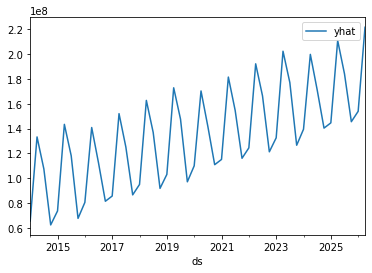

In [35]:
forecast.plot(x='ds', y='yhat')

In [36]:
def project_flat_growth(X, start="2019-04", stop="2020-03"):
    """Normalize future growth to be flat at the last annual period."""
    # Make a copy first
    X = X.copy()
    freq = X.index.inferred_freq
    X.index.freq = freq

    # This is the part that will be projected
    norm = X.loc[start:stop].copy()
    latest_date = norm.index[-1]

    # This should be monthly or quarterly
    assert len(norm) in [4, 12]
    if len(norm) == 4:
        key = lambda dt: dt.quarter
    else:
        key = lambda dt: dt.month

    # Reset the index to months/quarters
    norm.index = [key(dt) for dt in norm.index]

    # Change the forecast to be flat
    forecast_start = latest_date + latest_date.freq
    Y = X.loc[forecast_start:].copy()

    # Reset index
    i = Y.index
    Y.index = [key(dt) for dt in Y.index]

    # Overwrite
    Y.loc[:] = norm.loc[Y.index].values
    Y.index = i

    # Add back to original
    X.loc[Y.index] = Y.values

    return X

In [37]:
forecast = (
    forecast[
        [
            "ds",
            "yhat",
            "yhat_lower",
            "yhat_upper",
            "yearly",
            "trend",
        ]
    ]
    .rename(
        columns={
            "ds": "date",
            "yhat": "total",
            "yhat_lower": "lower",
            "yhat_upper": "upper",
        }
    )
    .set_index("date")
)

In [38]:
flat_forecast = project_flat_growth(forecast)

In [39]:
ratios = (unscaled_features[TAX_BASE_COLUMN] / flat_forecast["total"]).dropna()

In [40]:
ratios

2014-01-01    1.032520
2014-04-01    1.194696
2014-07-01    1.047753
2014-10-01    0.971201
2015-01-01    0.932984
2015-04-01    0.962583
2015-07-01    0.935072
2015-10-01    0.904353
2016-01-01    0.911528
2016-04-01    1.013381
2016-07-01    1.010955
2016-10-01    0.993323
2017-01-01    0.916889
2017-04-01    0.910542
2017-07-01    0.898217
2017-10-01    0.974997
2018-01-01    1.098072
2018-04-01    0.972129
2018-07-01    1.120972
2018-10-01    1.085353
2019-01-01    1.032862
2019-04-01    0.974449
2019-07-01    0.982677
2019-10-01    1.032601
2020-01-01    1.039602
2020-04-01    0.053095
2020-07-01    0.003948
2020-10-01    0.077497
2021-01-01    0.021487
2021-04-01    0.201935
dtype: float64

In [41]:
future_dates = pd.date_range("2021-07-01", "2026-06-30", freq="QS")

In [42]:
future_ratios = pd.Series(
    [
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.7,
        0.8,
        0.8,
        0.85,
        0.85,
        0.9,
        0.9,
        0.9,
        0.95,
        0.95,
        0.95,
        0.95,
        0.95,
        1.0,
        1.0,
    ],
    index=future_dates,
)

In [43]:
F = flat_forecast["total"].copy()
actuals = df.set_index("ds")["y"]
F = pd.concat([F.loc["2021-07-01":], actuals])

In [44]:
inter = F.index.intersection(future_ratios.index)
F.loc[inter] *= future_ratios.loc[inter].values

In [45]:
F2 = aggregate_to_fiscal_year(F).rename(columns={"total": TAX_BASE_COLUMN}).squeeze()

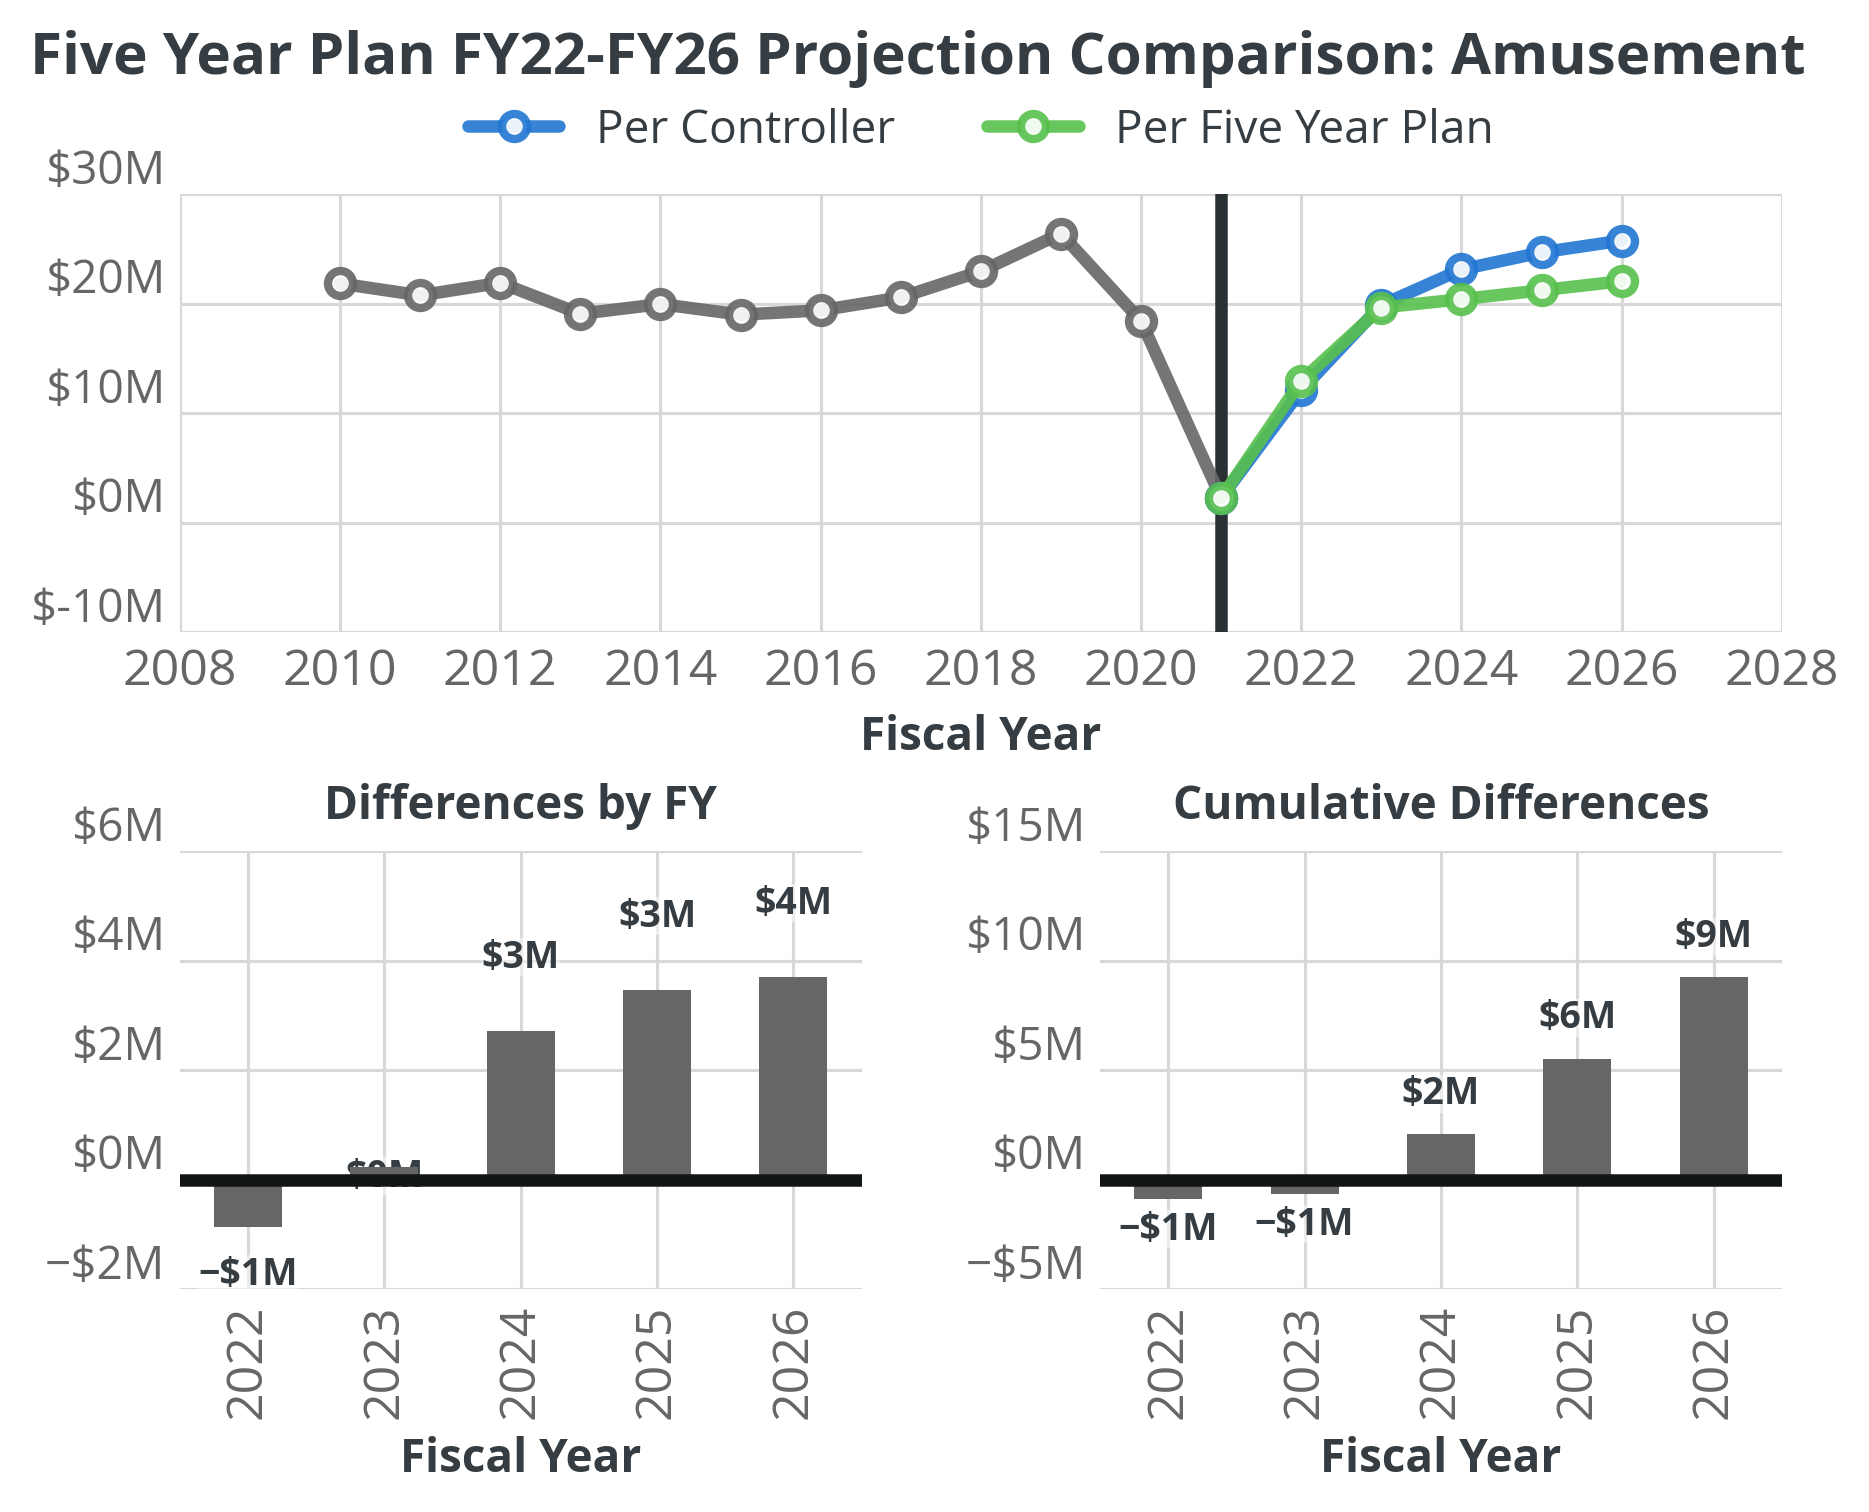

In [46]:
plot_projection_comparison(this_tax, F2.squeeze());

In [47]:
DATA.save("amusement_fit_params", future_ratios)

2021-07-05 13:36:36,053 - kedro.io.data_catalog - INFO - Saving data to `amusement_fit_params` (PickleDataSet)...
